# Use statistical visualization to understand the needs of your customers

In this blog article we make use of openly available data provided by Santander of Spain
for a data science competition held some time ago.
Check out the [Santander product recommendation challenge](https://www.kaggle.com/c/santander-product-recommendation)
for further details.

In this article we make use of statistical visualization library [seaborn](https://seaborn.pydata.org/)
which is freely available as open source package for the programming language Python.
The open source programming language Python is widely used by the data science / artificial intelligence community
along with a plethora of open source libraries such as seaborn and pandas (we use the latter to load and manipulate the data).

Let us get started by loading the respective libraries:

In [1]:
import warnings

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
pd.options.display.max_columns = 8
%matplotlib inline

The original Santander data set is fairly big (tens of millions of rows), which does not pose a technical
or ressource challenge on present-day hardware (e.g. MacBook Pro with 16 GB RAM).
While this amount of data does not pose a fundamental challenge to us it is not amenable to quick explorative
data visualization.

To this end we use a sample of the data in the present article:

In [2]:
df = pd.read_csv(
    'santander_sample.csv.zip',
    parse_dates=['date_partition', 'date_joined', 'date_primary_customer'],
    low_memory=False
)

The tabular data provided by Santander encompasses snapshots of the financial products held by each customer
(column `customer_id`) collected over multiple months (date column `date_partition`).
Each financial product is represented by a separate column and whether or not a given product is owned by a customer
is indicated by a binary `0` or `1` value:

In [3]:
df.head()

,date_partition,customer_id,employee_index,residence,...,product_home_account,product_payroll,product_pensions.1,product_direct_debit
0,2015-04-28,1155702,N,ES,...,0,0.0,0.0,0
1,2016-02-28,235866,N,ES,...,0,0.0,0.0,0
2,2015-04-28,1080714,N,ES,...,0,0.0,0.0,0
3,2015-07-28,939105,N,ES,...,0,0.0,0.0,0
4,2016-05-28,1248237,N,ES,...,0,0.0,0.0,0


In [4]:
product_columns = [c for c in df.columns if c.startswith('product_')]

In [5]:
len(product_columns)

24

Five of the 24 financial products represented in the data are:

In [6]:
product_columns[:5]

['product_savings_account',
 'product_guarantees',
 'product_current_account',
 'product_derivada_account',
 'product_payroll_account']

## Customer count

There are many summary metrics we can look at to start understanding the data.
One of these is the development of the number of customers over time.

To this end we count the number of unique customer IDs for each date provided in the Santander data:

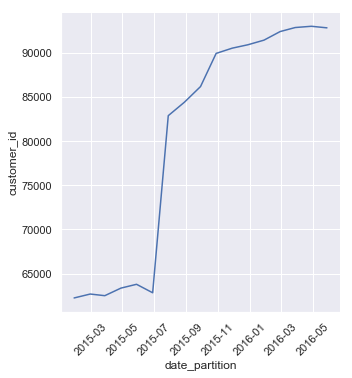

In [7]:
customers = df.groupby('date_partition').agg({'customer_id': 'nunique'}).reset_index()
graph = sns.relplot(x='date_partition', y='customer_id', kind='line', data=customers)
graph.set_xticklabels(rotation=45)
plt.show()

It appears Santander observed a spike of new customers around July 2015.

## Income analysis

A key aspect of our customers we may be interested in is their median gross income.
The Santander data set provides gross income for a number of customers.
We remove those customers from our analysis whose gross income is not provided.
We further only consider the gross income of those customers between ages 25 and 50.

In [8]:
income = df.loc[df['gross_income'].notnull()]
income = income.loc[(income['age'] >= 25) & (income['age'] <= 50)]

In [9]:
income = income.groupby(['age', 'province_name'])[['gross_income']].median()

In [10]:
income = income.reset_index().pivot('province_name', 'age', 'gross_income')

In [11]:
income = income.loc[income.isnull().sum(axis=1) < 10]

In [12]:
income['median'] = income.median(axis=1)
income = income.sort_values('median', axis=0)
del income['median']

Here we are interested in broad income trends across the age and residence of our customers.
To this end we visualize the median income as a heatmap against both age and providene of residence.
To simplify interpretation of this heatmap we focus on those provinces with lower overall median income.

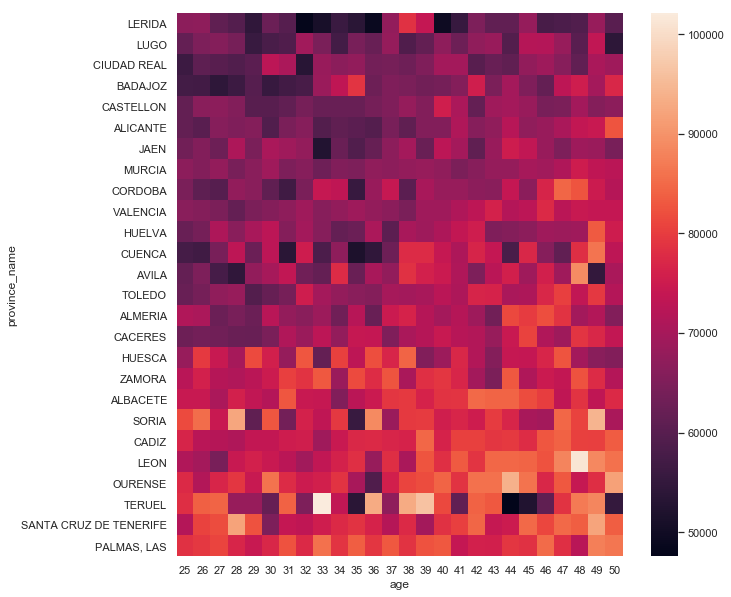

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(income.loc[income.median(axis=1) < 80000].fillna(0.), ax=ax)
plt.show()

The heatmap shows a broad trend of increasing median income top to bottom and with increasing age.

This analysis allows us to broadly understand the financial situation of our customers across
the country and may guide us in approaching customers in different age groups and provinces
with targeted offerings.

## Demographic analysis

To drill deeper into our data we plot the age distribution of our customers.
Achieving this is simple with the open source tools we use:
We merely select the age column of our tabular data, `df['age']`, and call the
distribution plot, `distplot`, functionality of the seaborn library:

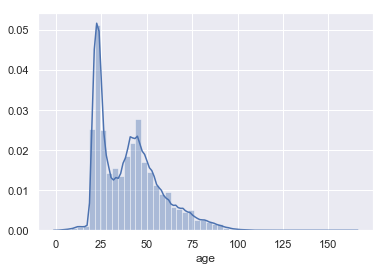

In [14]:
sns.distplot(df['age'])
plt.show()

The age distribution of customers has two modes (peaks): One mode around age 25 and another closer to 50.

To better understand the preferences and needs of our customers we will drill further into our data
by splitting our customers into *juniors* (those below the age of 30) and *seniors* (starting age 30 and above).
We will then compare the distribution of the most popular financial products between these two age groups.

In [15]:
frequent_products = [c for c in product_columns if df[c].sum() > 10000]

In [16]:
product_age = df.groupby('age')[frequent_products].sum().reset_index()

In [17]:
product_age = product_age.melt(id_vars=['age'], value_vars=frequent_products)

In [18]:
product_age['junior'] = product_age['age'] < 40

In [19]:
product_age = product_age.loc[(product_age['age'] >= 20) & (product_age['age'] <= 60)]

In [20]:
product_age = product_age.loc[~product_age['variable'].str.contains('current_account')]

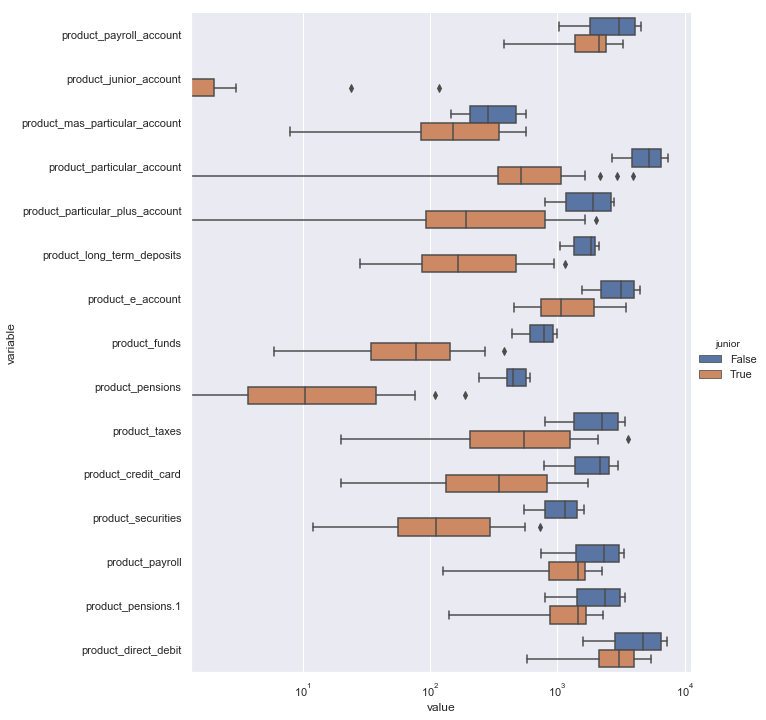

In [21]:
graph = sns.catplot(x='value', y='variable', hue='junior', kind='box', height=10, data=product_age)
graph.set(xscale='log')
plt.show()

Age-restricted financial products such as junior accounts (`products_junior_account`) are understandably
heteregeneously distributed between the two age groups.

Not surprisingly, investment-related financial products (`product_long_term_deposits`, `product_funds`, and `product_securities`) are more popular in the more senior age group.

Statistical visualization like this helps us communicate with our customers more productively:
We can communicate more frequently with our senior customers about products that are of interest to them.
We could further attempt designing new financial products in the investment category that may also
appeal to our more junior customers in order to increase our market share in that demographic.

## Customer lifetime analysis

A key component of business succsess is how long customers stay with a business (customer lifetime).
To analyze the impact of customer lifetime on our business we will now take a look
at the correlation between customer lifetime and the number of financial products retained.

To this end we count the number of products held and number of customers in each lifetime bucket (column `months_customer` in our tabular data):

In [22]:
lifetime_products = df.groupby('months_customer')[product_columns].sum().sum(axis=1).to_frame()
lifetime_products['no_products'] = lifetime_products[0]
del lifetime_products[0]
lifetime_customers = df.groupby('months_customer').agg({'customer_id': 'nunique'})
lifetime_customers['no_customers'] = lifetime_customers['customer_id']
del lifetime_customers['customer_id']

In [23]:
lifetime = lifetime_products.join(lifetime_customers)

We then divide the number of products held by the number of customers in each lifetime bucket:

In [24]:
lifetime['relative_product_count'] = lifetime['no_products'] / lifetime_customers['no_customers']

In [25]:
lifetime = lifetime.reset_index()

In [26]:
lifetime.head()

,months_customer,no_products,no_customers,relative_product_count
0,0,8242.0,13525,0.609390
1,1,11236.0,13117,0.856598
2,2,11826.0,12806,0.923473
3,3,12464.0,13129,0.949349
4,4,12334.0,12496,0.987036


Open-source library seaborn allows us to plot the customer-normalized / relative product count against
lifetime buckets while simultaneously fitting a linear model to the data:

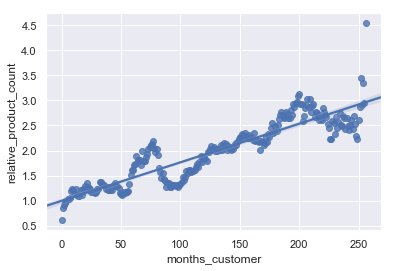

In [27]:
sns.regplot(x='months_customer', y='relative_product_count', data=lifetime)
plt.show()

Somewhat unsurprisingly the above plot shows a general increase in the number of products retained by
a customer with increasing customer lifetime.

Interestingly, the linear model we fit to this trend roughly indicates that customers who stay with us for an
additional 100 months (about eight years) will purchase one additional financial product.

We should now drill further into our data to understand the additional revenue generated on average by each
additional financial product purchased.
Combining this with an in-depth churn model (a predictive model that tells us which customers are most likely to leave)
allows us to efficiently use our ressources to retain those customers most likely to stay with us for at least another
eight years thus likely generating additional revenue.

## Product popularity and customer lifetime

We now have a rough understanding of the benefits of retaining customers - but what products should we recommend
to our customers?
Our above analysis showed clear trends in product preference in relation to customer age.

Here we will look at product preferences related to customer lifetime.
To this end we will count the per-product customers and compute the relative product retention per lifetime bucket.

In [28]:
lifetime_products = df.groupby('months_customer')[frequent_products].sum().reset_index()

In [29]:
lifetime_products = lifetime_products.melt(id_vars=['months_customer'], value_vars=frequent_products)

In [30]:
lifetime_products = lifetime_products.merge(lifetime_customers.reset_index())

In [31]:
lifetime_products['relative_product_count'] = lifetime_products['value'] / lifetime_products['no_customers']

In [32]:
lifetime_products.head()

,months_customer,variable,value,no_customers,relative_product_count
0,0,product_current_account,7576.0,13525,0.560148
1,0,product_payroll_account,55.0,13525,0.004067
2,0,product_junior_account,43.0,13525,0.003179
3,0,product_mas_particular_account,239.0,13525,0.017671
4,0,product_particular_account,0.0,13525,0.000000


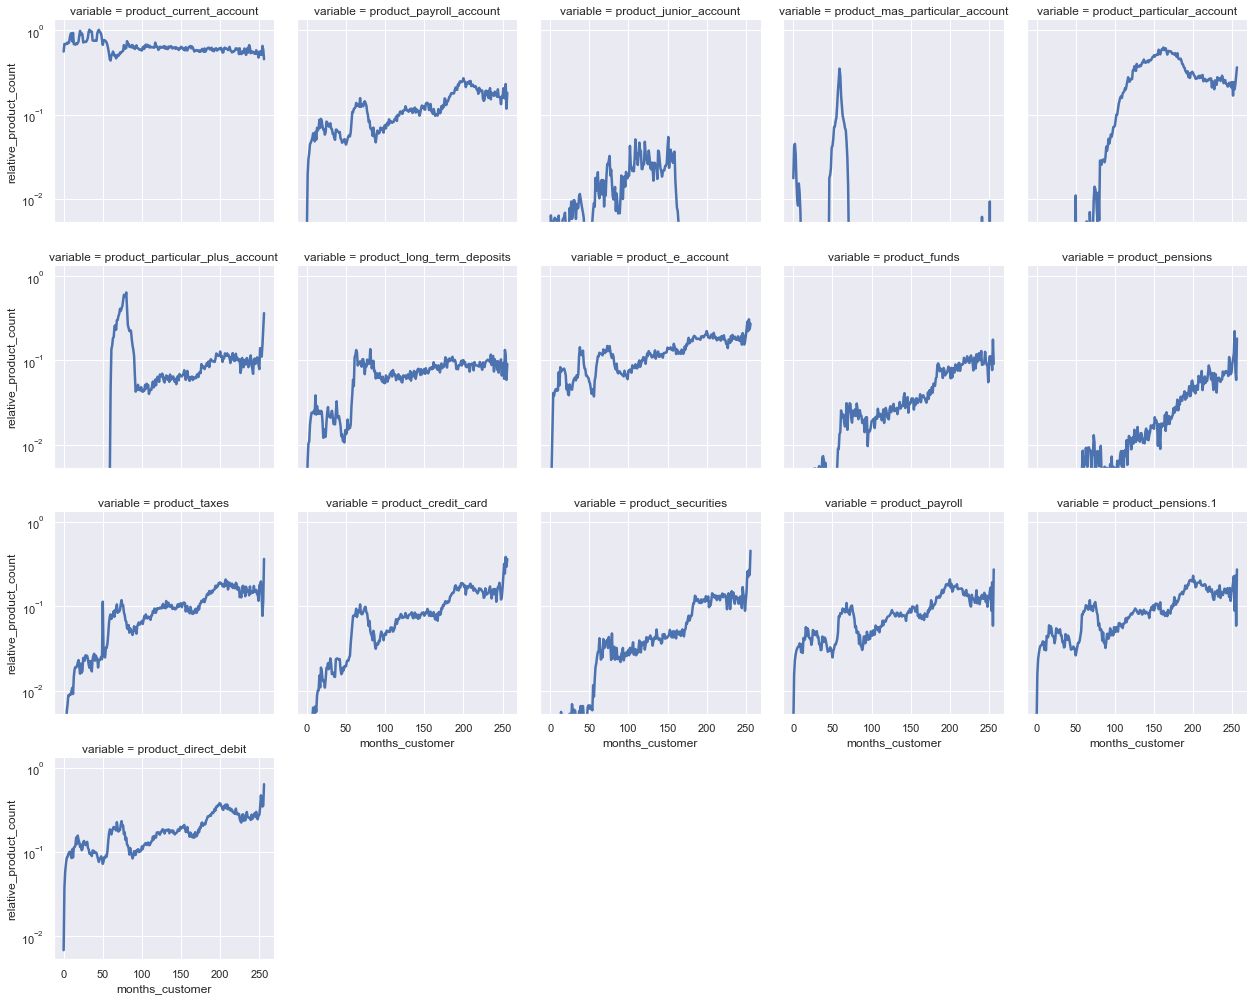

In [33]:
graph = sns.relplot(
    x='months_customer',
    y='relative_product_count',
    col='variable',
    col_wrap=5,
    height=3.5,
    linewidth=2.5,
    kind='line',
    data=lifetime_products
)
graph.set(yscale='log')
plt.show()

In this array of plots we can see that customer interest in current accounts (`product_current_account`) plateaus with customer lifetime.

A number of other financial products (`product_taxes`, `product_credit_card`, etc.) show a steady increase in
customer interest across their lifetime.

Interestingly, long term deposits (`product_long_term_deposits`) experience a sharp increase in interest around the
50 month customer lifetime bucket.

Well-placed communication about products with customers who show the greatest interest will likely help
retain these customers and prolong their lifetime with us.